In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import photoz_utils

In [3]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [4]:
from tensorflow_probability.python.distributions import kl_divergence

In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
n = 10000
t = 2000
v = 2000

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0:n],(0,2,3,1)))
x_test = np.asarray(np.transpose(hf_test['image'][0:t],(0,2,3,1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0:v],(0,2,3,1)))
max_value = np.max(np.array([np.max(x_train), np.max(x_test), np.max(x_validation)]))
x_train = np.true_divide(x_train,max_value)
x_test = np.true_divide(x_test,max_value)
x_validation = np.true_divide(x_validation,max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:n])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:t])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:v])[..., None]
object_id_train = np.asarray(hf_train['object_id'][0:n])
object_id = np.asarray(hf_test['object_id'][0:t])
object_id_validation = np.asarray(hf_validation['object_id'][0:v])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= 0 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=0.2),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [9]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [10]:
model_variational = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    tfpl.Convolution2DFlipout(32, kernel_size=(2, 2), activation = 'tanh', kernel_divergence_fn = kl_divergence_function),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    Dropout(0.2),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((10000, 127, 127, 5))

model_variational.summary()

/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (10000, 127, 127, 5)      0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (10000, 126, 126, 32)     1312      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (10000, 63, 63, 32)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (10000, 62, 62, 32)       4128      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (10000, 31, 31, 32)       0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (10000, 30, 30, 32)       4128      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (10000, 29, 29, 32)       4

In [11]:
def loss_function(targets, estimated_distribution):
    return - estimated_distribution.log_prob(targets) / (1 + targets)

model_variational.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [12]:
import tensorboard

model_name = 'HSC_v6_BCNN_v1'

checkpoint_filepath = os.path.join('/models/', model_name) + '/' + model_name

log_dir = os.path.join('/logs/', model_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [13]:
model_variational.fit(x = x_train, y = y_train, epochs = 1200, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [tensorboard_callback, cp_callback])

Epoch 1/1200
313/313 [==============================] - 413s 15ms/step - loss: 83.0320 - root_mean_squared_error: 2.8402 - val_loss: 70.4538 - val_root_mean_squared_error: 2.1401
Epoch 2/1200
313/313 [==============================] - 4s 11ms/step - loss: 65.3199 - root_mean_squared_error: 1.8256 - val_loss: 60.8007 - val_root_mean_squared_error: 1.6227
Epoch 3/1200
313/313 [==============================] - 4s 11ms/step - loss: 57.5518 - root_mean_squared_error: 1.5086 - val_loss: 54.7777 - val_root_mean_squared_error: 1.4229
Epoch 4/1200
313/313 [==============================] - 4s 11ms/step - loss: 52.8247 - root_mean_squared_error: 1.3617 - val_loss: 51.1662 - val_root_mean_squared_error: 1.3111
Epoch 5/1200
313/313 [==============================] - 4s 11ms/step - loss: 49.9087 - root_mean_squared_error: 1.2733 - val_loss: 48.7777 - val_root_mean_squared_error: 1.2417
Epoch 6/1200
313/313 [==============================] - 4s 11ms/step - loss: 47.7962 - root_mean_squared_error: 1

313/313 [==============================] - 4s 11ms/step - loss: 0.5932 - root_mean_squared_error: 0.8463 - val_loss: 0.7655 - val_root_mean_squared_error: 0.8443
Epoch 47/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.5772 - root_mean_squared_error: 0.8426 - val_loss: 0.5284 - val_root_mean_squared_error: 0.8408
Epoch 48/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.4969 - root_mean_squared_error: 0.8387 - val_loss: 0.3838 - val_root_mean_squared_error: 0.8368
Epoch 49/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.5019 - root_mean_squared_error: 0.8352 - val_loss: 0.3496 - val_root_mean_squared_error: 0.8333
Epoch 50/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.4621 - root_mean_squared_error: 0.8315 - val_loss: 0.3246 - val_root_mean_squared_error: 0.8295
Epoch 51/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.4371 - root_mean_squared_error: 0.8275 - val_loss: 0.3

313/313 [==============================] - 4s 11ms/step - loss: 0.1810 - root_mean_squared_error: 0.7352 - val_loss: 0.1628 - val_root_mean_squared_error: 0.7343
Epoch 93/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.1831 - root_mean_squared_error: 0.7334 - val_loss: 0.3723 - val_root_mean_squared_error: 0.7326
Epoch 94/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.3008 - root_mean_squared_error: 0.7318 - val_loss: 0.1634 - val_root_mean_squared_error: 0.7309
Epoch 95/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.1806 - root_mean_squared_error: 0.7300 - val_loss: 0.1338 - val_root_mean_squared_error: 0.7291
Epoch 96/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.1766 - root_mean_squared_error: 0.7282 - val_loss: 0.3400 - val_root_mean_squared_error: 0.7274
Epoch 97/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.1744 - root_mean_squared_error: 0.7266 - val_loss: 0.1

313/313 [==============================] - 4s 11ms/step - loss: 0.0646 - root_mean_squared_error: 0.6735 - val_loss: 0.1236 - val_root_mean_squared_error: 0.6730
Epoch 138/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0694 - root_mean_squared_error: 0.6725 - val_loss: 0.1000 - val_root_mean_squared_error: 0.6720
Epoch 139/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0710 - root_mean_squared_error: 0.6714 - val_loss: 0.0753 - val_root_mean_squared_error: 0.6709
Epoch 140/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0483 - root_mean_squared_error: 0.6704 - val_loss: 0.0814 - val_root_mean_squared_error: 0.6699
Epoch 141/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0577 - root_mean_squared_error: 0.6694 - val_loss: 0.0631 - val_root_mean_squared_error: 0.6689
Epoch 142/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0789 - root_mean_squared_error: 0.6683 - val_loss

313/313 [==============================] - 4s 11ms/step - loss: 0.0092 - root_mean_squared_error: 0.6323 - val_loss: 0.0688 - val_root_mean_squared_error: 0.6319
Epoch 184/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0321 - root_mean_squared_error: 0.6316 - val_loss: 0.0567 - val_root_mean_squared_error: 0.6312
Epoch 185/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0412 - root_mean_squared_error: 0.6309 - val_loss: 0.1397 - val_root_mean_squared_error: 0.6305
Epoch 186/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0386 - root_mean_squared_error: 0.6302 - val_loss: 0.0765 - val_root_mean_squared_error: 0.6298
Epoch 187/1200
313/313 [==============================] - 4s 11ms/step - loss: -4.7379e-04 - root_mean_squared_error: 0.6294 - val_loss: 0.0708 - val_root_mean_squared_error: 0.6291
Epoch 188/1200
313/313 [==============================] - 4s 11ms/step - loss: 0.0110 - root_mean_squared_error: 0.6286 - val

313/313 [==============================] - 4s 11ms/step - loss: -0.0171 - root_mean_squared_error: 0.6033 - val_loss: 0.0511 - val_root_mean_squared_error: 0.6030
Epoch 230/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0235 - root_mean_squared_error: 0.6028 - val_loss: 0.0412 - val_root_mean_squared_error: 0.6025
Epoch 231/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0157 - root_mean_squared_error: 0.6023 - val_loss: 0.0625 - val_root_mean_squared_error: 0.6020
Epoch 232/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0069 - root_mean_squared_error: 0.6017 - val_loss: 0.0382 - val_root_mean_squared_error: 0.6015
Epoch 233/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0339 - root_mean_squared_error: 0.6012 - val_loss: 0.1140 - val_root_mean_squared_error: 0.6009
Epoch 234/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0397 - root_mean_squared_error: 0.6006 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.0613 - root_mean_squared_error: 0.5819 - val_loss: 0.0720 - val_root_mean_squared_error: 0.5817
Epoch 275/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0586 - root_mean_squared_error: 0.5814 - val_loss: 0.0646 - val_root_mean_squared_error: 0.5812
Epoch 276/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0732 - root_mean_squared_error: 0.5810 - val_loss: 0.2128 - val_root_mean_squared_error: 0.5808
Epoch 277/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0537 - root_mean_squared_error: 0.5805 - val_loss: 0.0814 - val_root_mean_squared_error: 0.5803
Epoch 278/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0773 - root_mean_squared_error: 0.5802 - val_loss: 0.0391 - val_root_mean_squared_error: 0.5799
Epoch 279/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0676 - root_mean_squared_error: 0.5797 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.0804 - root_mean_squared_error: 0.5645 - val_loss: 0.1276 - val_root_mean_squared_error: 0.5643
Epoch 321/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0928 - root_mean_squared_error: 0.5641 - val_loss: 0.0633 - val_root_mean_squared_error: 0.5640
Epoch 322/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0638 - root_mean_squared_error: 0.5638 - val_loss: 0.0573 - val_root_mean_squared_error: 0.5636
Epoch 323/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0930 - root_mean_squared_error: 0.5634 - val_loss: 0.2296 - val_root_mean_squared_error: 0.5633
Epoch 324/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0951 - root_mean_squared_error: 0.5631 - val_loss: 0.1207 - val_root_mean_squared_error: 0.5629
Epoch 325/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0518 - root_mean_squared_error: 0.5628 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1049 - root_mean_squared_error: 0.5505 - val_loss: 0.0722 - val_root_mean_squared_error: 0.5504
Epoch 366/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1168 - root_mean_squared_error: 0.5502 - val_loss: 0.0814 - val_root_mean_squared_error: 0.5501
Epoch 367/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1081 - root_mean_squared_error: 0.5499 - val_loss: 0.0821 - val_root_mean_squared_error: 0.5498
Epoch 368/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0855 - root_mean_squared_error: 0.5496 - val_loss: 0.1407 - val_root_mean_squared_error: 0.5495
Epoch 369/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0781 - root_mean_squared_error: 0.5494 - val_loss: 0.0479 - val_root_mean_squared_error: 0.5493
Epoch 370/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1227 - root_mean_squared_error: 0.5491 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1331 - root_mean_squared_error: 0.5392 - val_loss: 0.1591 - val_root_mean_squared_error: 0.5391
Epoch 412/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1235 - root_mean_squared_error: 0.5390 - val_loss: 0.2296 - val_root_mean_squared_error: 0.5389
Epoch 413/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1287 - root_mean_squared_error: 0.5387 - val_loss: 0.0847 - val_root_mean_squared_error: 0.5386
Epoch 414/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1191 - root_mean_squared_error: 0.5385 - val_loss: 0.0799 - val_root_mean_squared_error: 0.5383
Epoch 415/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1300 - root_mean_squared_error: 0.5382 - val_loss: 0.0742 - val_root_mean_squared_error: 0.5381
Epoch 416/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1210 - root_mean_squared_error: 0.5380 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1515 - root_mean_squared_error: 0.5298 - val_loss: 0.0686 - val_root_mean_squared_error: 0.5297
Epoch 458/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1261 - root_mean_squared_error: 0.5296 - val_loss: 0.0038 - val_root_mean_squared_error: 0.5295
Epoch 459/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1231 - root_mean_squared_error: 0.5294 - val_loss: 0.1003 - val_root_mean_squared_error: 0.5294
Epoch 460/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1507 - root_mean_squared_error: 0.5293 - val_loss: 0.0099 - val_root_mean_squared_error: 0.5292
Epoch 461/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0885 - root_mean_squared_error: 0.5291 - val_loss: 0.0771 - val_root_mean_squared_error: 0.5290
Epoch 462/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.0985 - root_mean_squared_error: 0.5289 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.0520 - root_mean_squared_error: 0.5214 - val_loss: 0.0642 - val_root_mean_squared_error: 0.5213
Epoch 503/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1104 - root_mean_squared_error: 0.5213 - val_loss: 0.0508 - val_root_mean_squared_error: 0.5212
Epoch 504/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1487 - root_mean_squared_error: 0.5211 - val_loss: 0.1290 - val_root_mean_squared_error: 0.5210
Epoch 505/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1433 - root_mean_squared_error: 0.5209 - val_loss: 0.0319 - val_root_mean_squared_error: 0.5208
Epoch 506/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1376 - root_mean_squared_error: 0.5207 - val_loss: 0.0351 - val_root_mean_squared_error: 0.5206
Epoch 507/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1612 - root_mean_squared_error: 0.5205 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



313/313 [==============================] - 4s 11ms/step - loss: -0.1782 - root_mean_squared_error: 0.5076 - val_loss: 0.0535 - val_root_mean_squared_error: 0.5075
Epoch 593/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1621 - root_mean_squared_error: 0.5075 - val_loss: 0.0824 - val_root_mean_squared_error: 0.5074
Epoch 594/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1590 - root_mean_squared_error: 0.5073 - val_loss: 0.1788 - val_root_mean_squared_error: 0.5073
Epoch 595/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1791 - root_mean_squared_error: 0.5072 - val_loss: 0.0268 - val_root_mean_squared_error: 0.5071
Epoch 596/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1550 - root_mean_squared_error: 0.5071 - val_loss: 0.0848 - val_root_mean_squared_error: 0.5071
Epoch 597/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1609 - root_mean_squared_error: 0.5070 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1718 - root_mean_squared_error: 0.5019 - val_loss: 0.1192 - val_root_mean_squared_error: 0.5018
Epoch 638/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1937 - root_mean_squared_error: 0.5017 - val_loss: 0.1353 - val_root_mean_squared_error: 0.5017
Epoch 639/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1930 - root_mean_squared_error: 0.5016 - val_loss: 0.1122 - val_root_mean_squared_error: 0.5016
Epoch 640/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2022 - root_mean_squared_error: 0.5015 - val_loss: 0.1973 - val_root_mean_squared_error: 0.5014
Epoch 641/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1771 - root_mean_squared_error: 0.5014 - val_loss: 0.1192 - val_root_mean_squared_error: 0.5013
Epoch 642/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1841 - root_mean_squared_error: 0.5012 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1923 - root_mean_squared_error: 0.5006 - val_loss: 0.1623 - val_root_mean_squared_error: 0.5005
Epoch 684/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1938 - root_mean_squared_error: 0.5004 - val_loss: 0.0788 - val_root_mean_squared_error: 0.5004
Epoch 685/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1782 - root_mean_squared_error: 0.5003 - val_loss: 0.0947 - val_root_mean_squared_error: 0.5003
Epoch 686/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1871 - root_mean_squared_error: 0.5002 - val_loss: 0.0527 - val_root_mean_squared_error: 0.5002
Epoch 687/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1649 - root_mean_squared_error: 0.5001 - val_loss: 0.1862 - val_root_mean_squared_error: 0.5000
Epoch 688/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1975 - root_mean_squared_error: 0.5000 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1782 - root_mean_squared_error: 0.4958 - val_loss: 0.0699 - val_root_mean_squared_error: 0.4957
Epoch 729/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1911 - root_mean_squared_error: 0.4956 - val_loss: 0.0987 - val_root_mean_squared_error: 0.4956
Epoch 730/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2072 - root_mean_squared_error: 0.4955 - val_loss: 0.2200 - val_root_mean_squared_error: 0.4955
Epoch 731/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2113 - root_mean_squared_error: 0.4954 - val_loss: 0.0964 - val_root_mean_squared_error: 0.4954
Epoch 732/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1948 - root_mean_squared_error: 0.4953 - val_loss: 0.1076 - val_root_mean_squared_error: 0.4953
Epoch 733/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1991 - root_mean_squared_error: 0.4952 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.2110 - root_mean_squared_error: 0.4911 - val_loss: 0.0648 - val_root_mean_squared_error: 0.4911
Epoch 775/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2008 - root_mean_squared_error: 0.4911 - val_loss: 0.1136 - val_root_mean_squared_error: 0.4910
Epoch 776/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2141 - root_mean_squared_error: 0.4910 - val_loss: 0.2058 - val_root_mean_squared_error: 0.4909
Epoch 777/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2171 - root_mean_squared_error: 0.4909 - val_loss: 0.1851 - val_root_mean_squared_error: 0.4908
Epoch 778/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2051 - root_mean_squared_error: 0.4908 - val_loss: 0.0511 - val_root_mean_squared_error: 0.4907
Epoch 779/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2063 - root_mean_squared_error: 0.4907 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.0713 - root_mean_squared_error: 0.4877 - val_loss: 0.0839 - val_root_mean_squared_error: 0.4876
Epoch 821/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1384 - root_mean_squared_error: 0.4876 - val_loss: -2.8643e-04 - val_root_mean_squared_error: 0.4875
Epoch 822/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1835 - root_mean_squared_error: 0.4875 - val_loss: 0.1119 - val_root_mean_squared_error: 0.4875
Epoch 823/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2055 - root_mean_squared_error: 0.4874 - val_loss: 0.1307 - val_root_mean_squared_error: 0.4874
Epoch 824/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2103 - root_mean_squared_error: 0.4874 - val_loss: 0.0460 - val_root_mean_squared_error: 0.4873
Epoch 825/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1919 - root_mean_squared_error: 0.4873

313/313 [==============================] - 4s 11ms/step - loss: -0.2289 - root_mean_squared_error: 0.4840 - val_loss: 0.0764 - val_root_mean_squared_error: 0.4840
Epoch 866/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2204 - root_mean_squared_error: 0.4840 - val_loss: 0.0479 - val_root_mean_squared_error: 0.4839
Epoch 867/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1950 - root_mean_squared_error: 0.4839 - val_loss: 0.0714 - val_root_mean_squared_error: 0.4839
Epoch 868/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2143 - root_mean_squared_error: 0.4838 - val_loss: 0.0930 - val_root_mean_squared_error: 0.4838
Epoch 869/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2098 - root_mean_squared_error: 0.4838 - val_loss: 0.1104 - val_root_mean_squared_error: 0.4837
Epoch 870/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2126 - root_mean_squared_error: 0.4837 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.2114 - root_mean_squared_error: 0.4805 - val_loss: 0.1647 - val_root_mean_squared_error: 0.4805
Epoch 912/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2229 - root_mean_squared_error: 0.4804 - val_loss: 0.0938 - val_root_mean_squared_error: 0.4804
Epoch 913/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2333 - root_mean_squared_error: 0.4804 - val_loss: 0.1317 - val_root_mean_squared_error: 0.4804
Epoch 914/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2185 - root_mean_squared_error: 0.4803 - val_loss: 0.1062 - val_root_mean_squared_error: 0.4803
Epoch 915/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2239 - root_mean_squared_error: 0.4802 - val_loss: 0.1536 - val_root_mean_squared_error: 0.4802
Epoch 916/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2380 - root_mean_squared_error: 0.4802 - va

313/313 [==============================] - 4s 11ms/step - loss: -0.1368 - root_mean_squared_error: 0.4773 - val_loss: 0.0979 - val_root_mean_squared_error: 0.4772
Epoch 958/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2105 - root_mean_squared_error: 0.4772 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4772
Epoch 959/1200
146/313 [============>.................] - ETA: 1s - loss: -0.1366 - root_mean_squared_error: 0.4772
Epoch 00959: saving model to /models/HSC_v6_BCNN_v1/HSC_v6_BCNN_v1
313/313 [==============================] - 4s 12ms/step - loss: -0.1935 - root_mean_squared_error: 0.4772 - val_loss: 0.1032 - val_root_mean_squared_error: 0.4772
Epoch 960/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2316 - root_mean_squared_error: 0.4771 - val_loss: 0.1233 - val_root_mean_squared_error: 0.4771
Epoch 961/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2527 - root_mean_squared_error: 0.4771 - val_loss: 0.

313/313 [==============================] - 4s 11ms/step - loss: -0.2209 - root_mean_squared_error: 0.4743 - val_loss: 0.1529 - val_root_mean_squared_error: 0.4743
Epoch 1003/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2298 - root_mean_squared_error: 0.4742 - val_loss: 0.1034 - val_root_mean_squared_error: 0.4742
Epoch 1004/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2474 - root_mean_squared_error: 0.4742 - val_loss: 0.0810 - val_root_mean_squared_error: 0.4741
Epoch 1005/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2409 - root_mean_squared_error: 0.4741 - val_loss: 0.0556 - val_root_mean_squared_error: 0.4741
Epoch 1006/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2367 - root_mean_squared_error: 0.4740 - val_loss: 0.0727 - val_root_mean_squared_error: 0.4740
Epoch 1007/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2496 - root_mean_squared_error: 0.4740

Epoch 1048/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2386 - root_mean_squared_error: 0.4727 - val_loss: 0.2566 - val_root_mean_squared_error: 0.4726
Epoch 1049/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2089 - root_mean_squared_error: 0.4726 - val_loss: 0.1189 - val_root_mean_squared_error: 0.4726
Epoch 1050/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2249 - root_mean_squared_error: 0.4726 - val_loss: 0.1447 - val_root_mean_squared_error: 0.4725
Epoch 1051/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2323 - root_mean_squared_error: 0.4725 - val_loss: 0.2065 - val_root_mean_squared_error: 0.4725
Epoch 1052/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2425 - root_mean_squared_error: 0.4724 - val_loss: 0.2110 - val_root_mean_squared_error: 0.4724
Epoch 1053/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2115 - root_mean_squar

Epoch 1093/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2499 - root_mean_squared_error: 0.4701 - val_loss: 0.1686 - val_root_mean_squared_error: 0.4701
Epoch 1094/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2430 - root_mean_squared_error: 0.4700 - val_loss: 0.1502 - val_root_mean_squared_error: 0.4700
Epoch 1095/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2549 - root_mean_squared_error: 0.4700 - val_loss: 0.1513 - val_root_mean_squared_error: 0.4699
Epoch 1096/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1802 - root_mean_squared_error: 0.4699 - val_loss: 0.1566 - val_root_mean_squared_error: 0.4699
Epoch 1097/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.1785 - root_mean_squared_error: 0.4699 - val_loss: 0.0871 - val_root_mean_squared_error: 0.4699
Epoch 1098/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2420 - root_mean_squar

Epoch 1139/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2583 - root_mean_squared_error: 0.4676 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4676
Epoch 1140/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2628 - root_mean_squared_error: 0.4675 - val_loss: 0.2105 - val_root_mean_squared_error: 0.4675
Epoch 1141/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2626 - root_mean_squared_error: 0.4675 - val_loss: 0.3302 - val_root_mean_squared_error: 0.4674
Epoch 1142/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2381 - root_mean_squared_error: 0.4674 - val_loss: 0.1112 - val_root_mean_squared_error: 0.4674
Epoch 1143/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2434 - root_mean_squared_error: 0.4674 - val_loss: 0.1610 - val_root_mean_squared_error: 0.4673
Epoch 1144/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2630 - root_mean_squar

Epoch 1185/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2616 - root_mean_squared_error: 0.4652 - val_loss: 0.3812 - val_root_mean_squared_error: 0.4651
Epoch 1186/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2669 - root_mean_squared_error: 0.4651 - val_loss: 0.4091 - val_root_mean_squared_error: 0.4651
Epoch 1187/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2590 - root_mean_squared_error: 0.4651 - val_loss: 0.0998 - val_root_mean_squared_error: 0.4650
Epoch 1188/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2099 - root_mean_squared_error: 0.4650 - val_loss: 0.1397 - val_root_mean_squared_error: 0.4650
Epoch 1189/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2476 - root_mean_squared_error: 0.4649 - val_loss: 0.0387 - val_root_mean_squared_error: 0.4649
Epoch 1190/1200
313/313 [==============================] - 4s 11ms/step - loss: -0.2708 - root_mean_squar

In [14]:
model_variational.save(checkpoint_filepath, save_traces = False)

INFO:tensorflow:Assets written to: /models/HSC_v6_BCNN_v1/HSC_v6_BCNN_v1/assets


INFO:tensorflow:Assets written to: /models/HSC_v6_BCNN_v1/HSC_v6_BCNN_v1/assets


model_variational.load_weights(checkpoint_filepath)

In [15]:
photoz = []

for i in range(t):
    photoz.append(model_variational(np.array([x_test[i]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

In [16]:
photoz_train = []

for i in range(n):
    photoz_train.append(model_variational(np.array([x_train[i]])).mean()[0][0])

photoz_train = np.asarray(photoz_train).astype('float32')

In [17]:
photoz_validation = []

for i in range(v):
    photoz_validation.append(model_variational(np.array([x_validation[i]])).mean()[0][0])

photoz_validation = np.asarray(photoz_validation).astype('float32')

In [18]:
specz = np.asarray(y_test)[:,0]
specz_train = np.asarray(y_train)[:,0]
specz_validation = np.asarray(y_validation)[:,0]

In [19]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

In [20]:
photoz_err_train = []

for i in range(n):
    photoz_err_train.append(model_variational(np.array([x_train[i]])).stddev()[0][0])

In [21]:
photoz_err_validation = []

for i in range(v):
    photoz_err_validation.append(model_variational(np.array([x_validation[i]])).stddev()[0][0])

In [22]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)

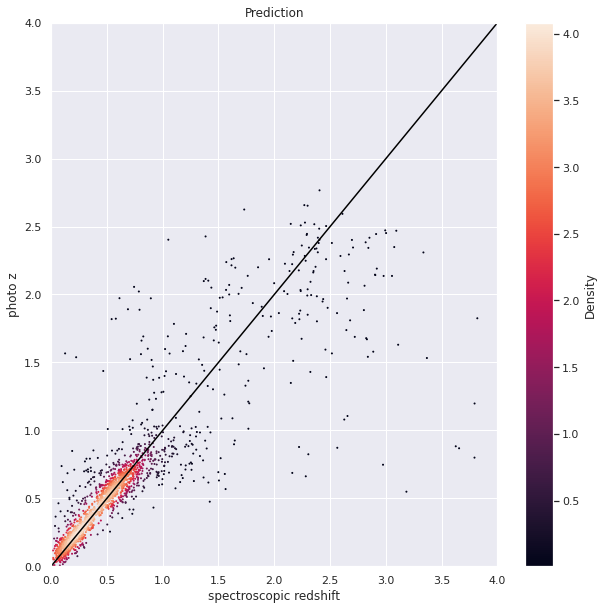

In [111]:
import seaborn as sns
z_max = 4
sns.set(rc={'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [24]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,t):
    if np.abs(specz[i]-photoz[i])<=photoz_err[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

Coverage: 0.564


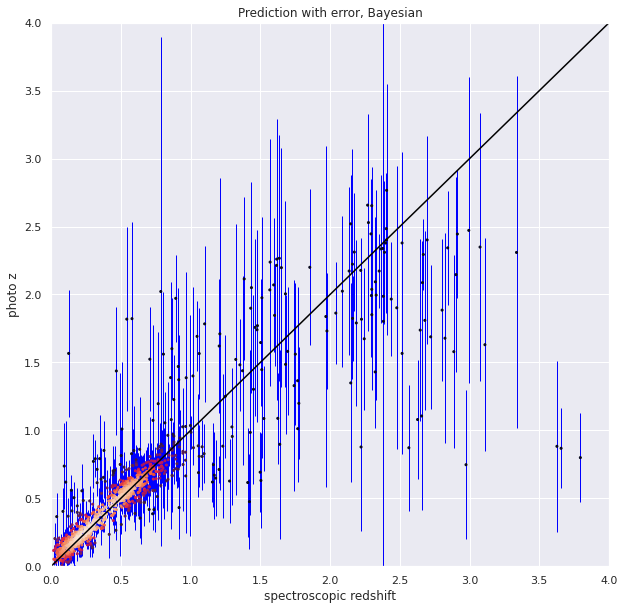

In [105]:
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[:display_size], photoz[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[:display_size], photoz[:display_size], yerr = photoz_err[:display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_variational/t))

In [26]:
combined_array_variational = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array_variational))) 

In [27]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [28]:
bins_variational = int(z_max*5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_variational)

Coverage: 0.564


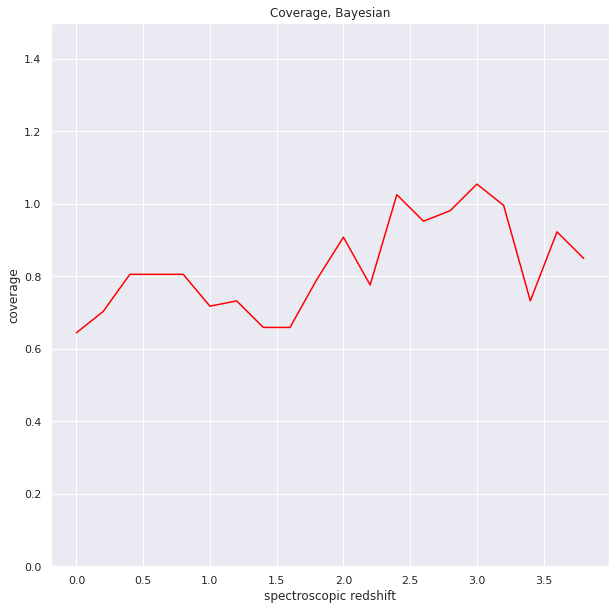

In [29]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
print("Coverage: "+str(overlap_variational/t))

In [30]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1]-splitted_sorted_combined_array_variational[i][j][0])
        total += bias
    mean_array.append(total/len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max/bins_variational)

In [31]:
error_array = []
for i in range(0,bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array_variational[i]))

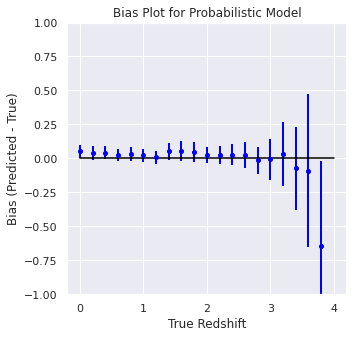

In [107]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, z_max], [0, 0],color = 'black')
plt.ylim([-1, 1])
plt.show()

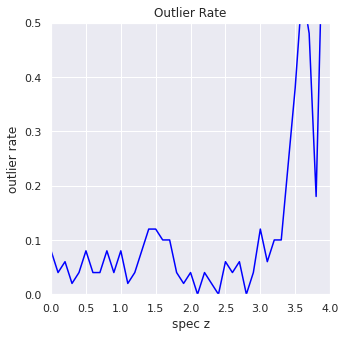

Outlier Rate: 0.1115


In [33]:
combined_outlier_array = np.transpose(np.vstack((specz,np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1]/(splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(specz)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate: "+str(outlier_count_total/len(specz)))

In [34]:
photoz_utils.save_with_oid_std(model_name, object_id, specz, photoz, photoz_err)
photoz_utils.save_train_with_oid_std(model_name, object_id_train, specz_train, photoz_train, photoz_err_train)
photoz_utils.save_validation_with_oid_std(model_name, object_id_validation, specz_validation, photoz_validation, photoz_err_validation)

In [51]:
uncertains = []
for i in range(0, len(photoz_err)):
    if photoz_err[i].numpy() >= 1:
        uncertains.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

Object ID: 37476613314602941, Spectro_z: 1.61732996, Photo_z: 2.260456, Photo_z_err: 1.0345666
Object ID: 37480577569395601, Spectro_z: 1.20987999, Photo_z: 1.7103279, Photo_z_err: 1.1454473
Object ID: 39627374022625510, Spectro_z: 1.96970606, Photo_z: 1.8379868, Photo_z_err: 1.2514095
Object ID: 40577231809941584, Spectro_z: 2.47814012, Photo_z: 1.9020046, Photo_z_err: 1.0403727
Object ID: 41557424951284390, Spectro_z: 2.99434996, Photo_z: 2.4718757, Photo_z_err: 1.1249719
Object ID: 41571177436575978, Spectro_z: 2.38218999, Photo_z: 1.802494, Photo_z_err: 2.7493687
Object ID: 41623545972813102, Spectro_z: 3.33641005, Photo_z: 2.3094418, Photo_z_err: 1.2946992
Object ID: 42050147894436943, Spectro_z: 0.786419988, Photo_z: 2.0221038, Photo_z_err: 1.8726912
Object ID: 42203808939409758, Spectro_z: 2.29003, Photo_z: 2.4382093, Photo_z_err: 1.2892765
Object ID: 42634684353483671, Spectro_z: 0.900699973, Photo_z: 1.5186164, Photo_z_err: 2.417241
Object ID: 42692116656170452, Spectro_z: 1.1

Object ID: 39627374022625510, Spectro_z: 1.96970606, Photo_z: 1.8379868, Photo_z_err: 1.2514095


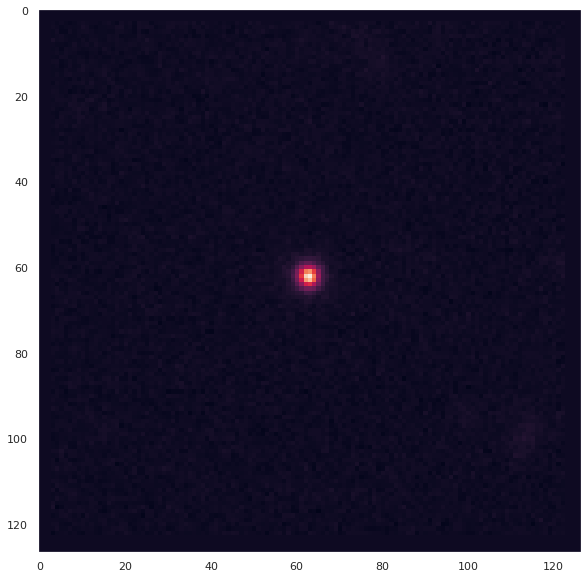

In [127]:
check = 2
current = uncertains[check]
print("Object ID: " + str(object_id[current]) + ", Spectro_z: " + str(specz[current]) + ", Photo_z: " + str(photoz[current]) + ", Photo_z_err: " + str(photoz_err[current].numpy()))
plt.imshow(x_test[current][:,:,0])
plt.grid(False)

In [99]:
biases = []
for i in range(0, len(photoz)):
    if np.abs(photoz[i]-specz[i]) >= 1 and photoz_err[i].numpy() <= 0.5:
        biases.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

Object ID: 38567182820442224, Spectro_z: 3.65606999, Photo_z: 0.868346, Photo_z_err: 0.29471755
Object ID: 39600861189505353, Spectro_z: 2.62730098, Photo_z: 1.0798981, Photo_z_err: 0.44075665
Object ID: 40585735845201736, Spectro_z: 2.56478, Photo_z: 0.87217414, Photo_z_err: 0.46521252
Object ID: 40977157689726672, Spectro_z: 3.79409003, Photo_z: 0.79974794, Photo_z_err: 0.32841697
Object ID: 42045599524064307, Spectro_z: 0.89368999, Photo_z: 1.9718974, Photo_z_err: 0.3197113
Object ID: 42050019045414454, Spectro_z: 0.125890002, Photo_z: 1.5665826, Photo_z_err: 0.47019792
Object ID: 42687873228476274, Spectro_z: 2.46544003, Photo_z: 1.3923765, Photo_z_err: 0.49693218
Object ID: 43158597349176799, Spectro_z: 2.2822001, Photo_z: 0.66212845, Photo_z_err: 0.47556755
Object ID: 43158734788109521, Spectro_z: 2.16140008, Photo_z: 0.68723017, Photo_z_err: 0.3996766
Object ID: 43237616157464975, Spectro_z: 3.36757994, Photo_z: 1.5326728, Photo_z_err: 0.2589628
Object ID: 70365462822670691, Spe

Object ID: 40977157689726672, Spectro_z: 3.79409003, Photo_z: 0.79974794, Photo_z_err: 0.32841697


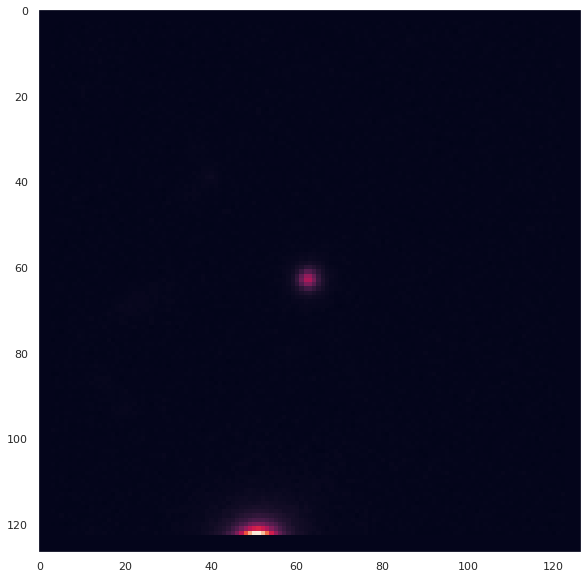

In [131]:
check_bias = 3
current_bias = biases[check_bias]
print("Object ID: " + str(object_id[current_bias]) + ", Spectro_z: " + str(specz[current_bias]) + ", Photo_z: " + str(photoz[current_bias]) + ", Photo_z_err: " + str(photoz_err[current_bias].numpy()))
plt.imshow(x_test[current_bias][:,:,0])
plt.grid(False)

In [35]:
# END